In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary
import matplotlib.pyplot as plt

In [0]:
# Create the data reader and transformer
train_transform = transforms.Compose([transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,))])


In [0]:
train = datasets.MNIST('./data',
                       train=True,
                       transform = train_transform,
                       download = True)
test = datasets.MNIST('./data',
                       train=False,
                       transform = test_transform,
                       download = True)

In [0]:
# Set seed for all the environments
SEED = 1
torch.manual_seed(SEED)

CUDA = torch.cuda.is_available()
print("CUDA is available:",CUDA)
# If CUDA is available the set SEED for it
if CUDA:
    torch.cuda.manual_seed(SEED)


CUDA is available: True


In [0]:
# DATA LOADER
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if CUDA else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train,**dataloader_args)
# test dataloader
test_loader = torch.utils.data.DataLoader(test,**dataloader_args)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # FIRST LAYER
        self.conv_block_1 =  nn.Sequential(nn.Conv2d(in_channels = 1,
                                                     out_channels = 8,
                                                     kernel_size=3, 
                                                     stride = 1,
                                                     padding=0,
                                                     bias=False
                                                     ),                          #output size = 26 Receptive field = 3
                                                     nn.BatchNorm2d(8),
                                                     nn.ReLU()
        )
        
        # CONVOLUTION BLOCK
        self.conv_block_2 = nn.Sequential(nn.Conv2d(in_channels=8,
                                                    out_channels=12,
                                                    kernel_size=3,
                                                    stride=1,
                                                    padding=0,
                                                    bias = False),                #Output Size = 24, Receptive Field = 5
                                          nn.BatchNorm2d(12),
                                          nn.ReLU(),
                                          nn.Dropout(0.08)
        ) 
        self.conv_block_3 = nn.Sequential(nn.Conv2d(in_channels=12,
                                                    out_channels=16,
                                                    kernel_size=3,
                                                    stride=1,
                                                    padding=0,
                                                    bias = False),                #Output size = 22 Receptive field = 7
                                          nn.BatchNorm2d(16),
                                          nn.ReLU(),
                                          nn.Dropout(0.10)
        )

        # TRANSITION BLOCK
        self.pool_1 = nn.Sequential(nn.MaxPool2d(kernel_size=2,
                                   stride=2,
                                   padding=0)                                    #Output size = 11 Receptive field = 8
         ) 
        self.conv_block_4 = nn.Sequential(nn.Conv2d(in_channels=16,
                                                    out_channels=8,
                                                    kernel_size=1,
                                                    stride=1,
                                                    padding=0,
                                                    bias = False),                #Output size = 11 Receptive field = 10
                                          nn.BatchNorm2d(8),
                                          nn.ReLU(),
                                          nn.Dropout(0.10)
        )

        # CONVOLUTION BLOCK
        self.conv_block_5 = nn.Sequential(nn.Conv2d(in_channels=8,
                                                    out_channels=12,
                                                    kernel_size=3,
                                                    stride=1,
                                                    padding=0,
                                                    bias = False),                #Output size = 9  Receptive field = 14
                                          nn.BatchNorm2d(12),
                                          nn.ReLU(),
                                          nn.Dropout(0.09)
        )
        self.conv_block_6 = nn.Sequential(nn.Conv2d(in_channels=12,
                                                    out_channels=16,
                                                    kernel_size=3,
                                                    stride=1,
                                                    padding=0,
                                                    bias = False),                #Output size = 7 Receptive field = 18
                                          nn.BatchNorm2d(16),
                                          nn.ReLU(),
                                          nn.Dropout(0.07)
        )
        self.conv_block_7 = nn.Sequential(nn.Conv2d(in_channels=16,
                                                    out_channels=16,
                                                    kernel_size=3,
                                                    stride=1,
                                                    padding=0,
                                                    bias = False),                #Output size = 5 Receptive field = 22
                                          nn.BatchNorm2d(16),
                                          nn.ReLU(),
                                          nn.Dropout(0.06)
        )
        
        # OUTPUT LAYER
        self.conv_block_8 = nn.Sequential(nn.Conv2d(in_channels=16,
                                                    out_channels=10,
                                                    kernel_size=1,
                                                    stride=1,
                                                    padding=0,
                                                    bias = False),                #Output size = 5 Receptive field = 24
                                          nn.BatchNorm2d(10),
                                          nn.ReLU(),
                                          nn.Dropout(0.06)
        )

        self.gap_layer = nn.Sequential(nn.AvgPool2d(5)) # output_size = 1
        self.conv_block_9 = nn.Sequential(nn.Conv2d(in_channels=10,
                                                    out_channels=10,
                                                    kernel_size=1,
                                                    stride=1,
                                                    padding=0,
                                                    bias = False)             #Output size = 5 Receptive field = 26
                                          
        )        
        #self.fc_layer = nn.Sequential(nn.Linear(10,10),nn.Dropout(0.05))

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.pool_1(x)
        x = self.conv_block_4(x)
        x = self.conv_block_5(x)
        x = self.conv_block_6(x)

        x = self.conv_block_7(x)
        x = self.conv_block_8(x)        
        x = self.gap_layer(x)
        #x = self.fc_layer(x)
        x = self.conv_block_9(x)
        x = x.view(-1, 10)
        final_x = F.log_softmax(x, dim=-1)
        return final_x

In [0]:
device = torch.device("cuda" if CUDA else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 12, 24, 24]             864
       BatchNorm2d-5           [-1, 12, 24, 24]              24
              ReLU-6           [-1, 12, 24, 24]               0
           Dropout-7           [-1, 12, 24, 24]               0
            Conv2d-8           [-1, 16, 22, 22]           1,728
       BatchNorm2d-9           [-1, 16, 22, 22]              32
             ReLU-10           [-1, 16, 22, 22]               0
          Dropout-11           [-1, 16, 22, 22]               0
        MaxPool2d-12           [-1, 16, 11, 11]               0
           Conv2d-13            [-1, 8, 11, 11]             128
      BatchNorm2d-14            [-

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.2209414392709732 Batch_id=468 Accuracy=71.69: 100%|██████████| 469/469 [00:14<00:00, 31.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1616, Accuracy: 9663/10000 (96.63%)

EPOCH: 1


Loss=0.08541844040155411 Batch_id=468 Accuracy=95.92: 100%|██████████| 469/469 [00:14<00:00, 31.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0829, Accuracy: 9790/10000 (97.90%)

EPOCH: 2


Loss=0.14155380427837372 Batch_id=468 Accuracy=97.11: 100%|██████████| 469/469 [00:14<00:00, 31.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9850/10000 (98.50%)

EPOCH: 3


Loss=0.09317608922719955 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:14<00:00, 31.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0624, Accuracy: 9821/10000 (98.21%)

EPOCH: 4


Loss=0.08318687975406647 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:14<00:00, 32.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9883/10000 (98.83%)

EPOCH: 5


Loss=0.05254621431231499 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:14<00:00, 32.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9891/10000 (98.91%)

EPOCH: 6


Loss=0.04699087515473366 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:14<00:00, 32.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9886/10000 (98.86%)

EPOCH: 7


Loss=0.013975177891552448 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:14<00:00, 32.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9895/10000 (98.95%)

EPOCH: 8


Loss=0.10069241374731064 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:14<00:00, 32.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9911/10000 (99.11%)

EPOCH: 9


Loss=0.13077618181705475 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:14<00:00, 32.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0385, Accuracy: 9879/10000 (98.79%)

EPOCH: 10


Loss=0.03053485043346882 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:14<00:00, 32.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9900/10000 (99.00%)

EPOCH: 11


Loss=0.03624488040804863 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:14<00:00, 32.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9901/10000 (99.01%)

EPOCH: 12


Loss=0.009802217595279217 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:14<00:00, 32.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9921/10000 (99.21%)

EPOCH: 13


Loss=0.1072971299290657 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:14<00:00, 32.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9927/10000 (99.27%)

EPOCH: 14


Loss=0.11300354450941086 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:14<00:00, 32.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9921/10000 (99.21%)

EPOCH: 15


Loss=0.03788190335035324 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:14<00:00, 32.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9910/10000 (99.10%)

EPOCH: 16


Loss=0.09918279200792313 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:14<00:00, 41.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9913/10000 (99.13%)

EPOCH: 17


Loss=0.006232982035726309 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:14<00:00, 32.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9923/10000 (99.23%)

EPOCH: 18


Loss=0.054612431675195694 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:14<00:00, 32.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9923/10000 (99.23%)

EPOCH: 19


Loss=0.07037606090307236 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:14<00:00, 32.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9905/10000 (99.05%)

EPOCH: 20


Loss=0.0607328824698925 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:14<00:00, 32.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9928/10000 (99.28%)

EPOCH: 21


Loss=0.04262469708919525 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:14<00:00, 32.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9923/10000 (99.23%)

EPOCH: 22


Loss=0.04471991956233978 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:14<00:00, 32.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9917/10000 (99.17%)

EPOCH: 23


Loss=0.09402638673782349 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9912/10000 (99.12%)

EPOCH: 24


Loss=0.050470102578401566 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:14<00:00, 32.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9918/10000 (99.18%)

EPOCH: 25


Loss=0.030580630525946617 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:14<00:00, 32.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9931/10000 (99.31%)

EPOCH: 26


Loss=0.02839055098593235 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:14<00:00, 32.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9914/10000 (99.14%)

EPOCH: 27


Loss=0.13686445355415344 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:14<00:00, 32.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9920/10000 (99.20%)

EPOCH: 28


Loss=0.04059340059757233 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:14<00:00, 31.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9926/10000 (99.26%)

EPOCH: 29


Loss=0.03427509218454361 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:14<00:00, 32.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9928/10000 (99.28%)

EPOCH: 30


Loss=0.030381901189684868 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:14<00:00, 33.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9928/10000 (99.28%)

EPOCH: 31


Loss=0.06327471882104874 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 40.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9935/10000 (99.35%)

EPOCH: 32


Loss=0.09713029116392136 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:14<00:00, 33.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9928/10000 (99.28%)

EPOCH: 33


Loss=0.023469233885407448 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:13<00:00, 33.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9940/10000 (99.40%)

EPOCH: 34


Loss=0.046178389340639114 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:13<00:00, 33.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9930/10000 (99.30%)

EPOCH: 35


Loss=0.01881798543035984 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 32.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9941/10000 (99.41%)

EPOCH: 36


Loss=0.08015944063663483 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 32.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9931/10000 (99.31%)

EPOCH: 37


Loss=0.02206897921860218 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:14<00:00, 39.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9935/10000 (99.35%)

EPOCH: 38


Loss=0.031578097492456436 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:14<00:00, 32.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9941/10000 (99.41%)

EPOCH: 39


Loss=0.052436381578445435 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:15<00:00, 31.23it/s]



Test set: Average loss: 0.0241, Accuracy: 9923/10000 (99.23%)



L1 Regularization

In [0]:
from tqdm import tqdm
from torch.autograd import Variable

train_losses_l1 = []
test_losses_l1 = []
train_acc_l1 = []
test_acc_l1 = []
LAMBDA=0.001
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    for param in model.parameters():
      L1_1 = Variable(param, requires_grad=True)
      L1_2 = torch.norm(L1_1, 1)
      L1_3 = LAMBDA * L1_2
    loss = loss + L1_3
    #print(l1_reg.shape)

    # Calculate loss
    train_losses_l1.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_l1.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_l1.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_l1.append(100. * correct / len(test_loader.dataset))

In [0]:
model_l1 = Net().to(device)
optimizer = optim.SGD(model_l1.parameters(), lr=0.1, momentum=0.9,nesterov=False)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model_l1, device, train_loader, optimizer, epoch)
    test(model_l1, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.2127363681793213 Batch_id=468 Accuracy=89.78: 100%|██████████| 469/469 [00:15<00:00, 30.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0567, Accuracy: 9819/10000 (98.19%)

EPOCH: 1


Loss=0.17137132585048676 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:15<00:00, 38.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0479, Accuracy: 9845/10000 (98.45%)

EPOCH: 2


Loss=0.15599089860916138 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:15<00:00, 30.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9869/10000 (98.69%)

EPOCH: 3


Loss=0.18557778000831604 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:16<00:00, 35.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9893/10000 (98.93%)

EPOCH: 4


Loss=0.10301032662391663 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:15<00:00, 30.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9900/10000 (99.00%)

EPOCH: 5


Loss=0.13079994916915894 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9909/10000 (99.09%)

EPOCH: 6


Loss=0.13486000895500183 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:15<00:00, 29.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.10699188709259033 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:15<00:00, 29.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9887/10000 (98.87%)

EPOCH: 8


Loss=0.16132445633411407 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:15<00:00, 30.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9922/10000 (99.22%)

EPOCH: 9


Loss=0.2968079745769501 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:15<00:00, 30.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9913/10000 (99.13%)

EPOCH: 10


Loss=0.15146638453006744 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:15<00:00, 30.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9923/10000 (99.23%)

EPOCH: 11


Loss=0.13994437456130981 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:15<00:00, 30.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9911/10000 (99.11%)

EPOCH: 12


Loss=0.10558506846427917 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:15<00:00, 30.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9909/10000 (99.09%)

EPOCH: 13


Loss=0.1616818904876709 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:15<00:00, 30.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9920/10000 (99.20%)

EPOCH: 14


Loss=0.10992876440286636 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9922/10000 (99.22%)

EPOCH: 15


Loss=0.1311846375465393 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:15<00:00, 30.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9923/10000 (99.23%)

EPOCH: 16


Loss=0.18522918224334717 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:15<00:00, 29.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Loss=0.1420665681362152 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:15<00:00, 38.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9928/10000 (99.28%)

EPOCH: 18


Loss=0.12165573239326477 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:15<00:00, 30.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9928/10000 (99.28%)

EPOCH: 19


Loss=0.17730313539505005 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:16<00:00, 28.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9921/10000 (99.21%)

EPOCH: 20


Loss=0.1440376192331314 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:16<00:00, 29.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9935/10000 (99.35%)

EPOCH: 21


Loss=0.17783206701278687 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:16<00:00, 29.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9932/10000 (99.32%)

EPOCH: 22


Loss=0.17378750443458557 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:16<00:00, 29.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9935/10000 (99.35%)

EPOCH: 23


Loss=0.11495313793420792 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:16<00:00, 28.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9927/10000 (99.27%)

EPOCH: 24


Loss=0.11381638795137405 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:16<00:00, 28.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9938/10000 (99.38%)

EPOCH: 25


Loss=0.11679335683584213 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 29.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9927/10000 (99.27%)

EPOCH: 26


Loss=0.14061392843723297 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:15<00:00, 29.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9917/10000 (99.17%)

EPOCH: 27


Loss=0.2152225822210312 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 29.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9935/10000 (99.35%)

EPOCH: 28


Loss=0.1329735815525055 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:15<00:00, 29.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9942/10000 (99.42%)

EPOCH: 29


Loss=0.1604861617088318 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:16<00:00, 28.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9933/10000 (99.33%)

EPOCH: 30


Loss=0.14965160191059113 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 29.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9947/10000 (99.47%)

EPOCH: 31


Loss=0.12786781787872314 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9931/10000 (99.31%)

EPOCH: 32


Loss=0.12907734513282776 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:15<00:00, 29.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9939/10000 (99.39%)

EPOCH: 33


Loss=0.11628292500972748 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:15<00:00, 29.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9928/10000 (99.28%)

EPOCH: 34


Loss=0.15895605087280273 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9937/10000 (99.37%)

EPOCH: 35


Loss=0.13069048523902893 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:15<00:00, 29.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9938/10000 (99.38%)

EPOCH: 36


Loss=0.13771063089370728 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 36.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9934/10000 (99.34%)

EPOCH: 37


Loss=0.13385017216205597 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:15<00:00, 37.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9934/10000 (99.34%)

EPOCH: 38


Loss=0.14920036494731903 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9930/10000 (99.30%)

EPOCH: 39


Loss=0.12682071328163147 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:15<00:00, 37.09it/s]



Test set: Average loss: 0.0200, Accuracy: 9942/10000 (99.42%)



L2 Regularization

In [0]:
from tqdm import tqdm
from torch.autograd import Variable

train_losses_l2 = []
test_losses_l2 = []
train_acc_l2 = []
test_acc_l2 = []
LAMBDA=0.0001
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    # Calculate loss
    train_losses_l2.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_l2.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_l2.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_l2.append(100. * correct / len(test_loader.dataset))

In [0]:
model_l2 = Net().to(device)
optimizer = optim.SGD(model_l2.parameters(), lr=0.1, momentum=0.9,nesterov=False, weight_decay=LAMBDA)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model_l2, device, train_loader, optimizer, epoch)
    test(model_l2, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.0717996209859848 Batch_id=468 Accuracy=90.11: 100%|██████████| 469/469 [00:16<00:00, 28.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0942, Accuracy: 9713/10000 (97.13%)

EPOCH: 1


Loss=0.05613003671169281 Batch_id=468 Accuracy=97.18: 100%|██████████| 469/469 [00:16<00:00, 28.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9863/10000 (98.63%)

EPOCH: 2


Loss=0.016827179118990898 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:16<00:00, 28.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9866/10000 (98.66%)

EPOCH: 3


Loss=0.046493906527757645 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:16<00:00, 28.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9884/10000 (98.84%)

EPOCH: 4


Loss=0.0879196748137474 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:15<00:00, 33.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9896/10000 (98.96%)

EPOCH: 5


Loss=0.03675955906510353 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:16<00:00, 29.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9906/10000 (99.06%)

EPOCH: 6


Loss=0.212550088763237 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:16<00:00, 29.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9873/10000 (98.73%)

EPOCH: 7


Loss=0.05044807866215706 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:16<00:00, 28.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9843/10000 (98.43%)

EPOCH: 8


Loss=0.11655326932668686 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:15<00:00, 29.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9917/10000 (99.17%)

EPOCH: 9


Loss=0.10865342617034912 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:16<00:00, 29.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9880/10000 (98.80%)

EPOCH: 10


Loss=0.039984043687582016 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9853/10000 (98.53%)

EPOCH: 11


Loss=0.01040742825716734 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:15<00:00, 29.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9909/10000 (99.09%)

EPOCH: 12


Loss=0.029549293220043182 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:15<00:00, 30.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9891/10000 (98.91%)

EPOCH: 13


Loss=0.058940667659044266 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:15<00:00, 30.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Loss=0.04083001986145973 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:15<00:00, 30.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9933/10000 (99.33%)

EPOCH: 15


Loss=0.01711142063140869 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:15<00:00, 30.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9912/10000 (99.12%)

EPOCH: 16


Loss=0.06787269562482834 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:15<00:00, 29.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9930/10000 (99.30%)

EPOCH: 17


Loss=0.04237468168139458 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:15<00:00, 30.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9895/10000 (98.95%)

EPOCH: 18


Loss=0.07575082033872604 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:15<00:00, 30.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9914/10000 (99.14%)

EPOCH: 19


Loss=0.11871790140867233 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:15<00:00, 29.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9928/10000 (99.28%)

EPOCH: 20


Loss=0.07028280198574066 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:15<00:00, 30.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9926/10000 (99.26%)

EPOCH: 21


Loss=0.028898412361741066 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:15<00:00, 30.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9924/10000 (99.24%)

EPOCH: 22


Loss=0.07140279561281204 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:15<00:00, 29.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9922/10000 (99.22%)

EPOCH: 23


Loss=0.03496905043721199 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:15<00:00, 30.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9923/10000 (99.23%)

EPOCH: 24


Loss=0.03574399650096893 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:15<00:00, 30.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9926/10000 (99.26%)

EPOCH: 25


Loss=0.09470987319946289 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:15<00:00, 30.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9922/10000 (99.22%)

EPOCH: 26


Loss=0.07581683248281479 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:15<00:00, 29.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9925/10000 (99.25%)

EPOCH: 27


Loss=0.029806971549987793 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:15<00:00, 29.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9924/10000 (99.24%)

EPOCH: 28


Loss=0.00801942776888609 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:15<00:00, 30.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9917/10000 (99.17%)

EPOCH: 29


Loss=0.03388886898756027 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:15<00:00, 29.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9937/10000 (99.37%)

EPOCH: 30


Loss=0.010696634650230408 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:15<00:00, 30.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9921/10000 (99.21%)

EPOCH: 31


Loss=0.06492792814970016 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:15<00:00, 30.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9936/10000 (99.36%)

EPOCH: 32


Loss=0.042359817773103714 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:15<00:00, 30.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9913/10000 (99.13%)

EPOCH: 33


Loss=0.013513808138668537 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:15<00:00, 30.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9937/10000 (99.37%)

EPOCH: 34


Loss=0.04507593810558319 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9923/10000 (99.23%)

EPOCH: 35


Loss=0.08919546008110046 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9930/10000 (99.30%)

EPOCH: 36


Loss=0.02199653722345829 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9944/10000 (99.44%)

EPOCH: 37


Loss=0.01550633180886507 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:15<00:00, 30.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9910/10000 (99.10%)

EPOCH: 38


Loss=0.0267233457416296 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:15<00:00, 30.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9929/10000 (99.29%)

EPOCH: 39


Loss=0.07044616341590881 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:15<00:00, 30.16it/s]



Test set: Average loss: 0.0209, Accuracy: 9937/10000 (99.37%)



L1 L2 Regularization

In [0]:
from tqdm import tqdm
from torch.autograd import Variable

train_losses_l1l2 = []
test_losses_l1l2 = []
train_acc_l1l2 = []
test_acc_l1l2 = []

LAMBDA=0.0001
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    for param in model.parameters():
      L1_1 = Variable(param, requires_grad=True)
      L1_2 = torch.norm(L1_1, 1)
      L1_3 = LAMBDA * L1_2
      L2_1 = Variable(param, requires_grad=True)
      L2_2 = torch.norm(L2_1, 2)
      L2_3 = LAMBDA * L2_2
    loss = loss + L1_3 + L2_3
    train_losses_l1l2.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_l1l2.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_l1l2.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_l1l2.append(100. * correct / len(test_loader.dataset))

In [0]:
model_l1l2 = Net().to(device)
optimizer = optim.SGD(model_l1l2.parameters(), lr=0.1, momentum=0.9,nesterov=False)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model_l1l2, device, train_loader, optimizer, epoch)
    test(model_l1l2, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.06608136743307114 Batch_id=468 Accuracy=90.67: 100%|██████████| 469/469 [00:16<00:00, 27.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0628, Accuracy: 9816/10000 (98.16%)

EPOCH: 1


Loss=0.1232118159532547 Batch_id=468 Accuracy=97.37: 100%|██████████| 469/469 [00:17<00:00, 27.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9878/10000 (98.78%)

EPOCH: 2


Loss=0.05269014090299606 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:16<00:00, 27.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Accuracy: 9875/10000 (98.75%)

EPOCH: 3


Loss=0.034512002021074295 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:17<00:00, 27.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9910/10000 (99.10%)

EPOCH: 4


Loss=0.02175096608698368 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:16<00:00, 27.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9912/10000 (99.12%)

EPOCH: 5


Loss=0.06065783277153969 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:16<00:00, 28.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9910/10000 (99.10%)

EPOCH: 6


Loss=0.039902932941913605 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:16<00:00, 33.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.11845797300338745 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:16<00:00, 35.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9921/10000 (99.21%)

EPOCH: 8


Loss=0.049764614552259445 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:16<00:00, 28.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9915/10000 (99.15%)

EPOCH: 9


Loss=0.020349998027086258 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:16<00:00, 28.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.06830485165119171 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:16<00:00, 27.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.03485354781150818 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:16<00:00, 27.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9917/10000 (99.17%)

EPOCH: 12


Loss=0.03876173123717308 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:16<00:00, 28.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9908/10000 (99.08%)

EPOCH: 13


Loss=0.027752989903092384 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:16<00:00, 28.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.025204170495271683 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:16<00:00, 27.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9908/10000 (99.08%)

EPOCH: 15


Loss=0.015452081337571144 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:16<00:00, 28.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9934/10000 (99.34%)

EPOCH: 16


Loss=0.05738557130098343 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:16<00:00, 28.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9925/10000 (99.25%)

EPOCH: 17


Loss=0.04042937234044075 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:16<00:00, 28.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9935/10000 (99.35%)

EPOCH: 18


Loss=0.04388199374079704 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:16<00:00, 27.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9918/10000 (99.18%)

EPOCH: 19


Loss=0.03981265425682068 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:16<00:00, 27.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9926/10000 (99.26%)

EPOCH: 20


Loss=0.02826339192688465 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:16<00:00, 28.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9932/10000 (99.32%)

EPOCH: 21


Loss=0.03951556980609894 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:16<00:00, 28.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9930/10000 (99.30%)

EPOCH: 22


Loss=0.06691069155931473 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:16<00:00, 27.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9927/10000 (99.27%)

EPOCH: 23


Loss=0.020170599222183228 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:16<00:00, 28.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9949/10000 (99.49%)

EPOCH: 24


Loss=0.0234762541949749 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:16<00:00, 27.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9939/10000 (99.39%)

EPOCH: 25


Loss=0.015788331627845764 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 28.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9938/10000 (99.38%)

EPOCH: 26


Loss=0.03763997554779053 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:16<00:00, 28.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9926/10000 (99.26%)

EPOCH: 27


Loss=0.05147400125861168 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:16<00:00, 28.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9926/10000 (99.26%)

EPOCH: 28


Loss=0.04420481622219086 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 27.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9936/10000 (99.36%)

EPOCH: 29


Loss=0.06640467047691345 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:16<00:00, 28.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9918/10000 (99.18%)

EPOCH: 30


Loss=0.03458939865231514 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 28.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9933/10000 (99.33%)

EPOCH: 31


Loss=0.031002813950181007 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:16<00:00, 27.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9944/10000 (99.44%)

EPOCH: 32


Loss=0.11904843896627426 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:16<00:00, 28.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9941/10000 (99.41%)

EPOCH: 33


Loss=0.14260290563106537 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:16<00:00, 28.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9945/10000 (99.45%)

EPOCH: 34


Loss=0.03911810740828514 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 28.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9939/10000 (99.39%)

EPOCH: 35


Loss=0.07388665527105331 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 28.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9943/10000 (99.43%)

EPOCH: 36


Loss=0.05103651061654091 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:16<00:00, 27.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9946/10000 (99.46%)

EPOCH: 37


Loss=0.057060256600379944 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:16<00:00, 28.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9929/10000 (99.29%)

EPOCH: 38


Loss=0.0307605043053627 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 28.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9935/10000 (99.35%)

EPOCH: 39


Loss=0.06565117090940475 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:16<00:00, 27.85it/s]



Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


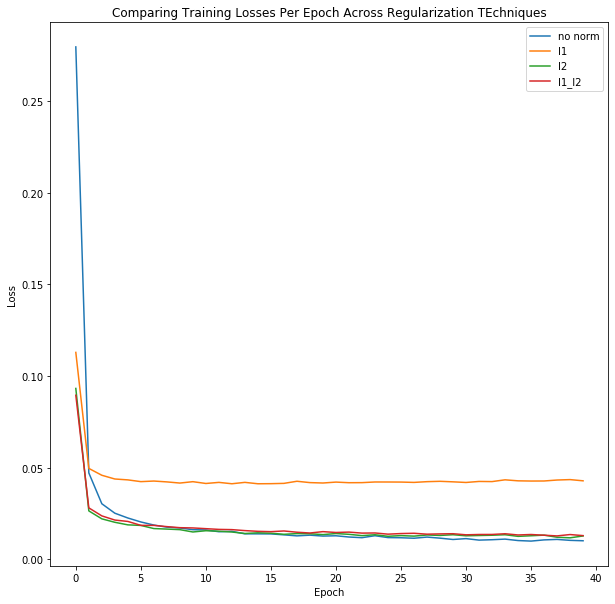

In [0]:
from pylab import rcParams
from google.colab import drive
drive.mount('/content/gdrive')
plot_save_name = 'train_losses.png'
path = F"/content/gdrive/My Drive/"+plot_save_name 
rcParams['figure.figsize'] = 10, 10
p=[]
q=[]
r=[]
s=[]
sum1=0.0
sum2=0.0
sum3=0.0
sum4=0.0
for i in range(0,len(train_losses)):
  if i !=0 and i!=4 and i%468 == 0:
    p.append(sum1/40)
    q.append(sum2/40)
    r.append(sum3/40)
    s.append(sum4/40)
    sum1 = 0.0
    sum2 = 0.0
    sum3 = 0.0
    sum4 = 0
  sum1 += train_losses[i]
  sum2 += train_losses_l1[i]
  sum3 += train_losses_l2[i]
  sum4 += train_losses_l1l2[i]
p = [x/40 for x in p]
q = [x/40 for x in q]
r = [x/40 for x in r]
s = [x/40 for x in s]
import matplotlib.pyplot as plt
plt.plot(p)
plt.plot(q)
plt.plot(r)
plt.plot(s)

plt.title('Comparing Training Losses Per Epoch Across Regularization TEchniques')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['no norm', 'l1', 'l2','l1_l2'], loc='best')
#plt.show()

from google.colab import files
plt.savefig("train_losses.png")
files.download("train_losses.png") 

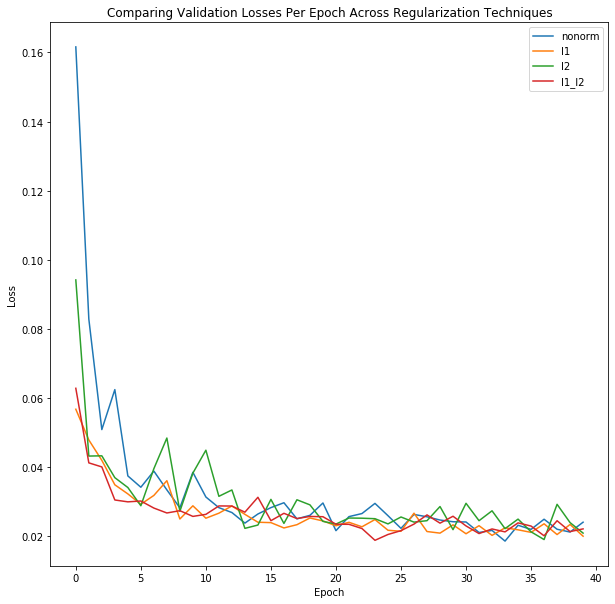

In [0]:
plt.plot(test_losses)
plt.plot(test_losses_l1)
plt.plot(test_losses_l2)
plt.plot(test_losses_l1l2)

plt.title('Comparing Validation Losses Per Epoch Across Regularization Techniques')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['nonorm', 'l1', 'l2','l1_l2'], loc='best')
plt.savefig("validation_losses.png")
files.download("validation_losses.png") 

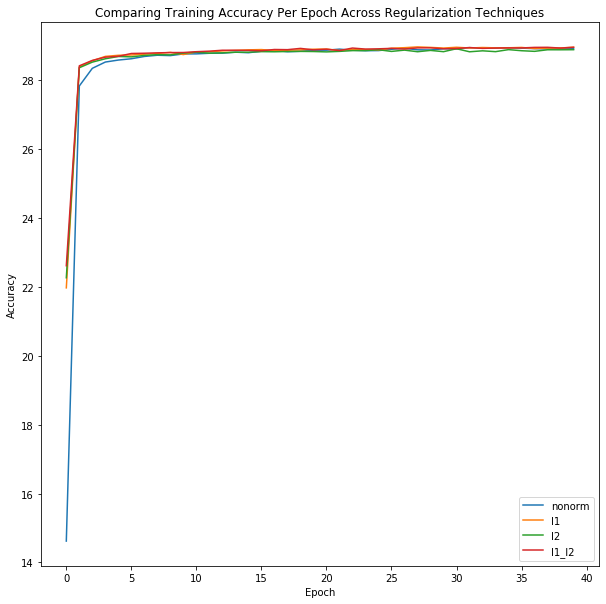

In [0]:
p=[]
q=[]
r=[]
s=[]
sum1=0.0
sum2=0.0
sum3=0.0
sum4=0.0
for i in range(0,len(train_losses)):
  if i !=0 and i!=4 and i%468 == 0:
    p.append(sum1/40)
    q.append(sum2/40)
    r.append(sum3/40)
    s.append(sum4/40)
    sum1 = 0.0
    sum2 = 0.0
    sum3 = 0.0
    sum4 = 0
  sum1 += train_acc[i]
  sum2 += train_acc_l1[i]
  sum3 += train_acc_l2[i]
  sum4 += train_acc_l1l2[i]
p = [x/40 for x in p]
q = [x/40 for x in q]
r = [x/40 for x in r]
s = [x/40 for x in s]
import matplotlib.pyplot as plt
plt.plot(p)
plt.plot(q)
plt.plot(r)
plt.plot(s)

plt.title('Comparing Training Accuracy Per Epoch Across Regularization Techniques')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['nonorm', 'l1', 'l2','l1_l2'], loc='best')
plt.savefig("training_accuracy.png")
files.download("training_accuracy.png") 

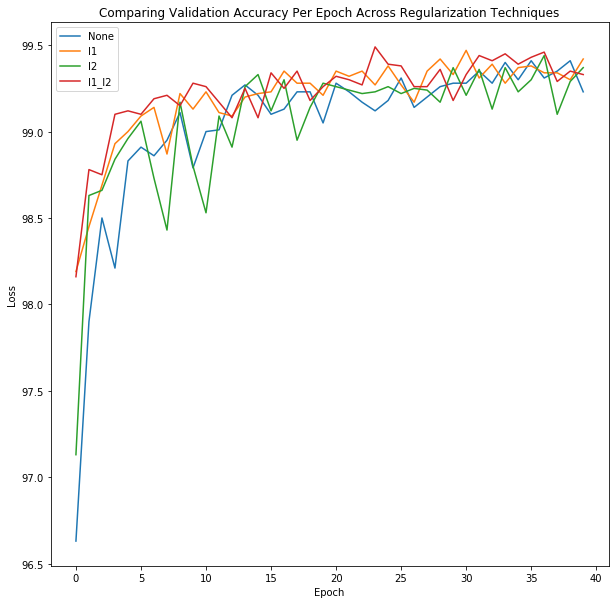

In [0]:
plt.plot(test_acc)
plt.plot(test_acc_l1)
plt.plot(test_acc_l2)
plt.plot(test_acc_l1l2)

plt.title('Comparing Validation Accuracy Per Epoch Across Regularization Techniques')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['None', 'l1', 'l2','l1_l2'], loc='best')
plt.savefig("validation_accuracy.png")
files.download("validation_accuracy.png") 

In [0]:
from torch.autograd import Variable
model_l1.eval()
correct = 0
total = 0
incorrect_examples=[]
incorrect_prediction=[]
actual_result=[]
result = []
for (i, [images, labels]) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)
    outputs = model_l1(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)                    
    correct += (predicted == labels).sum() 
    if (predicted != labels).sum() > 0:
      idxs_mask = (predicted == labels).view(-1)
      incorrect_examples.append(images[idxs_mask==False].squeeze(1).cpu().numpy()) 
      incorrect_prediction.append(predicted[idxs_mask==False])
      actual_result.append(labels[idxs_mask==False])

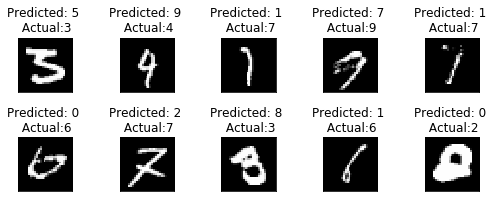

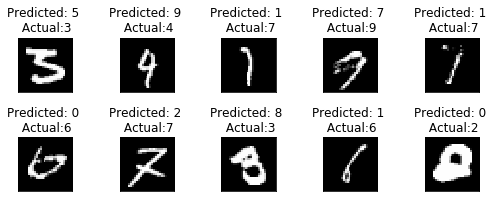

In [0]:
rcParams['figure.figsize'] = 7,7

import matplotlib.pyplot as plt
fig = plt.figure()

data, target = images.to('cpu'), labels.to('cpu')
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(incorrect_examples[i][0], cmap='gray', interpolation='none')
  plt.title("Predicted: {} \n Actual:{}".format(
    incorrect_prediction[i][0], actual_result[i][0]))
  plt.xticks([])
  plt.yticks([])
fig
# fig.savefig("misclass_l1.png")
# files.download("misclass_l1.png") 

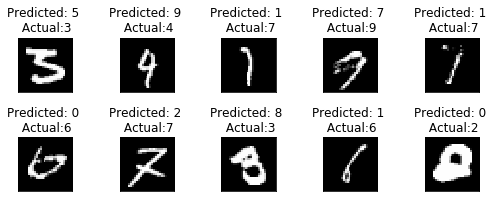

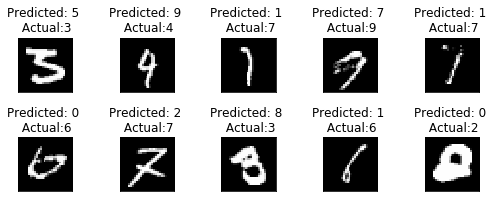

In [0]:
from torch.autograd import Variable
model_l1.eval()
correct = 0
total = 0
incorrect_examples=[]
incorrect_prediction=[]
actual_result = []
result = []
for (i, [images, labels]) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)
    outputs = model_l2(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)                    
    correct += (predicted == labels).sum() 
    if (predicted != labels).sum() > 0:
      idxs_mask = (predicted == labels).view(-1)
      incorrect_examples.append(images[idxs_mask==False].squeeze(1).cpu().numpy()) 
      incorrect_prediction.append(predicted[idxs_mask==False])
      actual_result.append(labels[idxs_mask==False])
import matplotlib.pyplot as plt
fig = plt.figure()
data, target = images.to('cpu'), labels.to('cpu')
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(incorrect_examples[i][0], cmap='gray', interpolation='none')
  plt.title("Predicted: {} \n Actual:{}".format(
    incorrect_prediction[i][0], actual_result[i][0]))
  plt.xticks([])
  plt.yticks([])
fig